<a href="https://colab.research.google.com/github/ANNL-ILPHY/Code-sharing/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis 


In [ ]:
import codecs
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np
from sklearn.preprocessing import label_binarize
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import joblib
from sklearn.metrics import auc
from scipy import interp
import itertools

matplotlib.rcParams['axes.unicode_minus'] = False
import warnings

warnings.filterwarnings('ignore')

### Part 1.a. Loading and Prep

Load, clean, and preprocess the data as you find necessary.

In [ ]:
import pandas as pd

df_train = pd.read_csv("train.csv")

print(df_train.info())
print(df_train.head())

df_test = pd.read_csv("test.csv")

print(df_train.info())
print(df_train.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train[:3]

,Sentence,Polarity
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0


In [ ]:
test[:3]

,Sentence,Polarity
0,A good commentary of today's love and undoubte...,1
1,For people who are first timers in film making...,1
2,"It was very popular when I was in the cinema, ...",1


In [ ]:
# checked the balance level of trainning dataset
train['Polarity'].value_counts()

0    1213
1    1187
Name: Polarity, dtype: int64

The ratio between class 1 and 0 of 'Polarity' is closed to 1, thus this is a balanced dataset.

In [ ]:
test['Polarity'].value_counts()

1    313
0    287
Name: Polarity, dtype: int64

Preprocessing data

In [ ]:
# Stopwords 
stopword = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

def cut_word(s):
    
    s = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', str(s))
    s = word_tokenize(s)
    
    sa = []
    for k in s:
        k = k.lower()
        # Lemmatizing process
        k = wordnet_lemmatizer.lemmatize(k, 'n')
        k = wordnet_lemmatizer.lemmatize(k, 'v')
        sa.append(k)
    outstr = ''
    for word in sa:
        r = re.sub('[^a-zA-Z]', '', word)
        if len(r) > 1 and r not in stopword:
            outstr += word
            outstr += " "
    return outstr[:-1]

In [ ]:
# Applied cut_word in train and test sets

train['Sentence_cut'] = train['Sentence'].apply(cut_word)
test['Sentence_cut'] = test['Sentence'].apply(cut_word)

In [ ]:
train[:3]

,Sentence,Polarity,Sentence_cut
0,Wow... Loved this place.,1,wow love place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasty texture wa nasty


Vectors Transformed

In [ ]:
"""
Transformed text to feature vectors 
"""
tv = TfidfVectorizer(min_df=3,max_df=0.9,sublinear_tf=True)
tfidf_train = tv.fit_transform(train['Sentence_cut']).toarray()  
vocab = tv.get_feature_names()

tfidf_test = tv.transform(test['Sentence_cut']).toarray()
print("train.shape" + repr(tfidf_train.shape))
print("test.shape" + repr(tfidf_test.shape))

tfidf_train = pd.DataFrame(tfidf_train, columns=vocab)
tfidf_test = pd.DataFrame(tfidf_test, columns=vocab)

train.shape(2400, 937)
test.shape(600, 937)


In [ ]:
tfidf_train[:3]

,able,absolutely,access,act,action,actor,actually,add,addition,adorable,...,wow,wrap,write,wrong,year,yes,yet,young,yummy,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.754437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ML algorithm 


# Decision Tree

In [ ]:
#Hyperparameter tuning

parameters_ = { 'max_features': ['auto','sqrt','log2'],
               'splitter': ['best', 'random'],
               'criterion':['gini','entropy']} 
model_tree = DecisionTreeClassifier(random_state=40)
tree_cv = GridSearchCV(model_tree, parameters_, n_jobs=-1, scoring='accuracy', cv=5)
tree_cv.fit(tfidf_train,train['Polarity'])
print('dt_best_paras：',tree_cv.best_params_)
print('best_score：',tree_cv.best_score_)

dt_best_paras： {'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}
best_score： 0.74125


In [ ]:
#Trained and Predicted with best parameters

model_tree = DecisionTreeClassifier(max_features='auto', criterion='entropy', splitter='best', random_state=40)
model_tree.fit(tfidf_train,train['Polarity'])

pred_tree = model_tree.predict(tfidf_test)
pred_tree_prob = model_tree.predict_proba(tfidf_test)

acc_tree = accuracy_score(test['Polarity'], pred_tree)
f1_tree = f1_score(test['Polarity'], pred_tree)

print("dt_Accuracy", accuracy_score(test['Polarity'], pred_tree))
print("dt_Precision", precision_score(test['Polarity'], pred_tree))
print("dt_Recall", recall_score(test['Polarity'], pred_tree))
print("dt_F1_score", f1_score(test['Polarity'], pred_tree))
tree_confusion_matrix_result = confusion_matrix(test['Polarity'], pred_tree)
print('confusion_matrix：\n',tree_confusion_matrix_result)
print("dt_ROC", roc_auc_score(test['Polarity'],pred_tree_prob[:,1]))

dt_Accuracy 0.71
dt_Precision 0.7813765182186235
dt_Recall 0.6166134185303515
dt_F1_score 0.6892857142857144
confusion_matrix：
 [[233  54]
 [120 193]]
dt_ROC 0.7275550756420388


# Random Forest

In [ ]:
#Hyperparameter tuning

parameters = {
 'max_depth': np.arange(14, 17),
 'max_features': ['auto','sqrt','log2'],
 'n_estimators': [100,200,300],
'criterion':['gini','entropy']
}
model_rf = RandomForestClassifier(n_estimators=100, random_state=40)
rf_cv = GridSearchCV(model_rf, parameters, n_jobs=-1, scoring='accuracy', cv=5)
rf_cv.fit(tfidf_train,train['Polarity'])
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 300}
0.7641666666666668


In [ ]:
#Trained and Predicted with best parameters

model_rf = RandomForestClassifier(max_depth=15, n_estimators=300,  max_features='log2',criterion='entropy', random_state=40)
model_rf.fit(tfidf_train,train['Polarity'])

pred_rf = model_rf.predict(tfidf_test)
pred_rf_prob = model_rf.predict_proba(tfidf_test)

acc_rf = accuracy_score(test['Polarity'], pred_rf)
f1_rf = f1_score(test['Polarity'], pred_rf)

print("rf_Accuracy", accuracy_score(test['Polarity'], pred_rf))
print("rf_Precision", precision_score(test['Polarity'], pred_rf))
print("rf_Recall", recall_score(test['Polarity'], pred_rf))
print("rf_F1_score", f1_score(test['Polarity'], pred_rf))
rf_confusion_matrix_result = confusion_matrix(test['Polarity'], pred_rf)
print('confusion_matrix：\n',tree_confusion_matrix_result)
print("rf_ROC", roc_auc_score(test['Polarity'],pred_tree_prob[:,1]))

rf_Accuracy 0.7083333333333334
rf_Precision 0.8876404494382022
rf_Recall 0.5047923322683706
rf_F1_score 0.6435845213849288
confusion_matrix：
 [[233  54]
 [120 193]]
rf_ROC 0.7275550756420388


# Multinomial Naive Bayes

In [ ]:
#Hyperparameter tuning

parameters_ = { 'alpha': [0.001, 0.01, 0.1, 1, 10]} 
model_mnb = MultinomialNB(alpha=0.1)
mnb_cv = GridSearchCV(model_mnb, parameters_, n_jobs=-1, scoring='accuracy', cv=5)
mnb_cv.fit(tfidf_train,train['Polarity'])
print('mnb_cv_best_params：',mnb_cv.best_params_)
print('best_score：',mnb_cv.best_score_)

mnb_cv_best_params： {'alpha': 1}
best_score： 0.7845833333333332


In [ ]:
#Trained and Predicted with best parameters

model_mnb = MultinomialNB(alpha=1)
model_mnb.fit(tfidf_train, train['Polarity'])

pred_mnb = model_mnb.predict(tfidf_test)
pred_mnb_proba = model_mnb.predict_proba(tfidf_test)

acc_mnb = accuracy_score(test['Polarity'], pred_mnb)
f1_mnb = f1_score(test['Polarity'], pred_mnb)

print("mnb_Accuracy", accuracy_score(test['Polarity'], pred_mnb))
print("mnb_Precision", precision_score(test['Polarity'], pred_mnb))
print("mnb_Recall", recall_score(test['Polarity'], pred_mnb))
print("mnb_F1_score", f1_score(test['Polarity'], pred_mnb))
# confusion_matrix
mnb_confusion_matrix_result = confusion_matrix(test['Polarity'], pred_mnb)
print('confusion_matrix：\n',mnb_confusion_matrix_result)
print("mnb_ROC", roc_auc_score(test['Polarity'],pred_mnb_proba[:,1]))

mnb_Accuracy 0.7333333333333333
mnb_Precision 0.8097165991902834
mnb_Recall 0.6389776357827476
mnb_F1_score 0.7142857142857143
confusion_matrix：
 [[240  47]
 [113 200]]
mnb_ROC 0.8477084748026851


# Support Vector Machines (Linear SVC)

In [ ]:
#Hyperparameter tuning

parameters_ = { 'max_iter': [100, 200, 300], 
               'tol':[0.0001, 0.001,0.01, 0.1], 
               'C':[0.01, 0.1 , 1, 10]} 
model_svc = LinearSVC(random_state=10)
svc_cv = GridSearchCV(model_svc, parameters_, n_jobs=-1, scoring='accuracy', cv=5)
svc_cv.fit(tfidf_train,train['Polarity'])
print('SVM_best_param：',svc_cv.best_params_)
print('best_score：',svc_cv.best_score_)

SVM_best_param： {'C': 0.1, 'max_iter': 100, 'tol': 0.0001}
best_score： 0.7879166666666667


In [ ]:
#Trained and Predicted with best parameters

model_svc = LinearSVC(C=0.1, max_iter=100, tol=0.0001, random_state=10)
model_svc.fit(tfidf_train, train['Polarity'])
pred_svc = model_svc.predict(tfidf_test)
pred_svc_proba = model_svc._predict_proba_lr(tfidf_test)

acc_svc = accuracy_score(test['Polarity'], pred_svc)
f1_svc = f1_score(test['Polarity'], pred_svc)

print("SVM_Accuracy", accuracy_score(test['Polarity'], pred_svc))
print("SVM_Precision", precision_score(test['Polarity'], pred_svc))
print("SVM_Recall", recall_score(test['Polarity'], pred_svc))
print("SVM_F1_score", f1_score(test['Polarity'], pred_svc))

# confusion_matrix
svc_confusion_matrix_result = confusion_matrix(test['Polarity'], pred_svc)
print('confusion_matrix：\n',svc_confusion_matrix_result)
print("SVM_ROC", roc_auc_score(test['Polarity'],pred_svc_proba[:,1]))

SVM_Accuracy 0.7466666666666667
SVM_Precision 0.851528384279476
SVM_Recall 0.6230031948881789
SVM_F1_score 0.7195571955719556
confusion_matrix：
 [[253  34]
 [118 195]]
SVM_ROC 0.8434115171822645


# Logistic Regression

In [ ]:
#Hyperparameter tuning

parameters_ = { 'max_iter': [100, 200, 300],
               'tol':[0.0001, 0.001,0.01, 0.1], 
               'C':[0.01, 0.1 , 1, 10],
               'solver':['newton-cg','lbfgs','liblinear','sag','saga']} 
model_lr = LogisticRegression(random_state=10)
lr_cv = GridSearchCV(model_lr, parameters_, n_jobs=-1, scoring='accuracy', cv=5)
lr_cv.fit(tfidf_train,train['Polarity'])
print('lr_best_params：',lr_cv.best_params_)
print('lr_best_score：',lr_cv.best_score_)

lr_best_params： {'C': 1, 'max_iter': 100, 'solver': 'saga', 'tol': 0.1}
lr_best_score： 0.7899999999999999


In [ ]:
#Trained and Predicted with best parameters

model_lr = LogisticRegression(C=1, max_iter=100, solver='saga', random_state=10)
model_lr.fit(tfidf_train, train['Polarity'])

pred_lr = model_lr.predict(tfidf_test)
pred_lr_proba = model_lr.predict_proba(tfidf_test)

acc_lr = accuracy_score(test['Polarity'], pred_lr)
f1_lr = f1_score(test['Polarity'], pred_lr)

print("lr_Accuracy", accuracy_score(test['Polarity'], pred_lr))
print("lr_Precision", precision_score(test['Polarity'], pred_lr))
print("lr_Recall", recall_score(test['Polarity'], pred_lr))
print("lr_F1_score", f1_score(test['Polarity'], pred_lr))
lr_confusion_matrix_result = confusion_matrix(test['Polarity'], pred_lr)
print('confusion_matrix：\n',lr_confusion_matrix_result)
print("lr_ROC", roc_auc_score(test['Polarity'],pred_lr_proba[:,1]))

lr_Accuracy 0.7433333333333333
lr_Precision 0.8471615720524017
lr_Recall 0.6198083067092651
lr_F1_score 0.7158671586715867
confusion_matrix：
 [[252  35]
 [119 194]]
lr_ROC 0.844903207133395


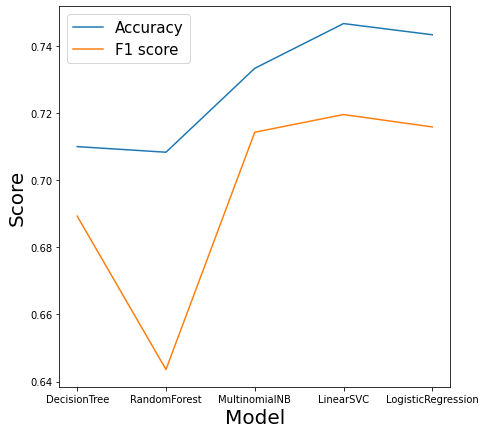

In [ ]:
plt.figure(figsize=(7, 7))
model_all = ['DecisionTree','RandomForest','MultinomialNB','LinearSVC','LogisticRegression']
acc_all = [acc_tree, acc_rf, acc_mnb, acc_svc, acc_lr]
f1_all = [f1_tree, f1_rf, f1_mnb, f1_svc, f1_lr]

plt.plot(model_all, acc_all, label='Accuracy')
plt.plot(model_all, f1_all, label='F1 score')
plt.xlabel('Model', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(fontsize=10)
plt.legend(fontsize=15, loc = 'upper left')


After the comparison among above five models, the Linear SVC can give me the highest accuracy and F1-score; thus I will use this model to do further process.

In [ ]:
model_svc.fit(tfidf_train, train['Polarity'])
pred_svc = model_svc.predict(tfidf_test)
pred_svc_proba = model_svc._predict_proba_lr(tfidf_test)

acc_svc = accuracy_score(test['Polarity'], pred_svc)
f1_svc = f1_score(test['Polarity'], pred_svc)

In [ ]:
print("Accuracy", accuracy_score(test['Polarity'], pred_svc))
print("F1_score", f1_score(test['Polarity'], pred_svc))

Accuracy 0.7466666666666667
F1_score 0.7195571955719556
